In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


# Data

In [2]:
url = "https://raw.githubusercontent.com/RomanovIV/hse_home_projects/master/"

def read_data(file, col_name):
    df = pd.read_csv(file)
    df.columns = ["date", col_name]
    df["date"] = pd.to_datetime(df["date"], dayfirst=True)
    df.sort_values(by="date", inplace=True)
    return df

df = read_data(url+"data/ruonia.csv", "r_hm")
df = df.merge(read_data(url+"data/LIBOR%20USD.csv", "r_fr"), on="date", how="outer")
df = df.merge(read_data(url+"data/usd_exch_rate.csv", "fx"), on="date", how="outer")
df.dropna(inplace=True)
df["fx"] = 1/df["fx"]
df["r_hm"] = df["r_hm"]/100
df["r_fr"] = df["r_fr"]/100
df.head()

,date,r_hm,r_fr,fx
1,2015-01-13,0.1719,0.001167,0.015940
2,2015-01-14,0.1707,0.001196,0.015422
3,2015-01-15,0.1710,0.001201,0.015129
4,2015-01-16,0.1693,0.001201,0.015424
6,2015-01-20,0.1697,0.001208,0.015391


# Risk Factors

## Simulation

In [3]:
from scipy.linalg import cholesky

cov_mat = np.concatenate([
    np.diff(df["r_hm"])[:, None],
    np.diff(df["r_fr"])[:, None],
    (np.diff(df["fx"])/np.array(df["fx"])[:-1])[:, None]
], axis=1).T

cov_mat = np.cov(cov_mat)
chol = cholesky(cov_mat, lower=True)
chol

array([[ 2.43057610e-03,  0.00000000e+00,  0.00000000e+00],
       [-1.72670202e-06,  2.54416293e-04,  0.00000000e+00],
       [ 6.78997179e-04, -2.22866126e-04,  1.31547885e-02]])

In [0]:
steps = 252*2
n_sim = 5
dt = 1/252

dw = np.random.normal(size=(3,n_sim,steps))
dw = np.tensordot(chol, dw, axes=1)

In [0]:
def gen_Vasicek(dw, a, b, sigma, dt, steps, r0, n_sim):
    r = np.zeros(shape=(n_sim, steps+1))
    r[:,0] = r0
    for i in range(1, steps+1):
        r[:,i] = a*b*dt +(1-a*dt)*r[:,i-1] + sigma*dw[:,i-1]
    return r[:,1:]

def fx_simulate(dw, fx0, r_fr_sim, r_hm_sim, drift, sigma, dt, n_sim, steps):
    
    assert r_fr_sim.shape == (n_sim, steps)
    assert r_hm_sim.shape == (n_sim, steps)
    
    dfx_fx = np.zeros(shape=(n_sim, steps+1))
    dfx_fx[:,0] = fx0
    
    for i in range(1, steps+1):
        dfx_fx[:,i] = (r_hm_sim[:,i-1] - r_fr_sim[:,i-1] + drift)*dt + sigma*dw[:,i-1] + 1
    fx_sim = np.cumprod(dfx_fx, axis=1)
    
    return fx_sim[:,1:]

In [0]:
fx_start = 1/69.4706 # на 30.12.2018
dt=1/252
r_hm_params = {"a":0.3, "b":0.3/10, "sigma":0.03, "dt":dt, "steps":steps,
               "r0":df["r_hm"].tolist()[-1], "n_sim":n_sim}
r_fr_params = {"a":0.063, "b":0.03/10, "sigma":0.0093, "dt":dt, "steps":steps,
               "r0":df["r_fr"].tolist()[-1], "n_sim":n_sim}
fx_params = {"drift":0.015, "sigma":0.11, "dt":dt, "steps":steps, "fx0":fx_start, "n_sim":n_sim}

In [0]:
r_hm_sim = gen_Vasicek(dw=dw[1,:,:], **r_hm_params)
r_fr_sim = gen_Vasicek(dw=dw[2,:,:], **r_fr_params)

In [8]:
df["r_hm"].mean(), df["r_fr"].mean()

(0.09825427069645197, 0.008537961892247046)

In [0]:
fx_sim = fx_simulate(dw=dw[2,:,:], r_hm_sim=r_hm_sim, r_fr_sim=r_fr_sim, **fx_params)

## Visualisation

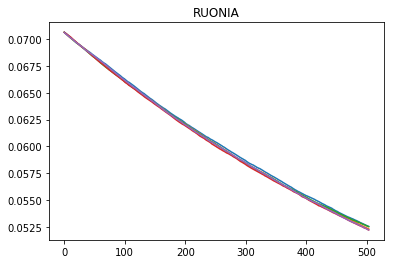

In [10]:
pd.DataFrame(r_hm_sim.T[:,:100]).plot(legend=False)
plt.title('RUONIA');

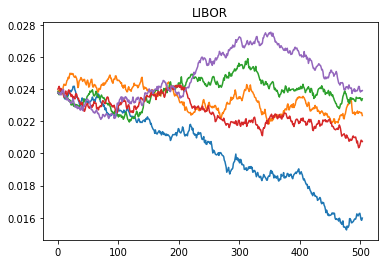

In [11]:
pd.DataFrame(r_fr_sim.T[:,:100]).plot(legend=False)
plt.title('LIBOR');

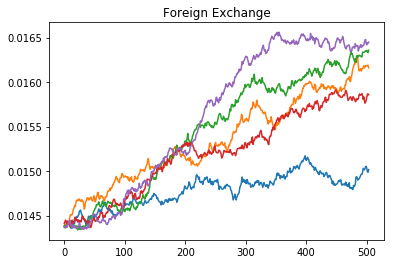

In [12]:
pd.DataFrame(data=fx_sim.T[:,:100]).plot(legend=False)
plt.title('Foreign Exchange');

# Zero-Coupon Yield Curve

## Modeling

In [13]:
from scipy.optimize import minimize 
import numpy as np
import matplotlib.pyplot as plt

### Моделирование кривой доходности по безрисковым активам.
### На 29.12.18 данные с ЦБ. 
### Time to maturity
t_actual = [0.25,0.5, 0.75, 1.00, 2.00, 3.00, 5.00]
yield_actual = [7.12, 7.23, 7.33, 7.45, 7.86, 8.16, 8.51]
pr_p_actual = []
for t,p in zip(t_actual, yield_actual):
    pr_p_actual.append(1/(1+t*p/100))
print(pr_p_actual)

[0.982511298879937, 0.9651112290691503, 0.947889760420863, 0.9306654257794322, 0.8641548565502938, 0.8033419023136246, 0.701508242721852]


In [14]:
### Функции
def VasicekPath(T,params,N):
    a,b,s,r0 = params[0], params[1], params[2], params[3]
    dt = T/N
    t = np.linspace(0,T,N)
    r, B = np.zeros(N), np.zeros(N)
    B[0] = 1
    r[0] = r0
    for i in range(1,N):
        r[i] = r[i-1] + a*(b-r[i-1])*dt + s*np.sqrt(dt)*np.random.randn()
        B[i] = B[i-1] + r[i-1]*B[i-1]*dt
    return (r, B, t)
def PriceZeroCouponBond(params, T, n_sim, N):
    res = np.zeros(n_sim)
    for i in range(n_sim):
        (r,B,t) = VasicekPath(T,params, N)
        res[i] = 1 / B[-1]
    return np.mean(res)
def sum_min(params):
    N = 100
    M = 100
    s = [(PriceZeroCouponBond(params, t_actual[i], N, M) - pr_p_actual[i])**2 for i in range(len(t_actual))]
    return np.sum(s)
### Начальные условия
x0 = [0,0,0,0.05]
cons = ({'type': 'ineq', 'fun': lambda x: -x[0]},
        {'type': 'ineq', 'fun': lambda x: -x[1]},
        {'type': 'ineq', 'fun': lambda x:  x[2] - 1},
        {'type': 'ineq', 'fun': lambda x: -x[2]},
        {'type': 'ineq', 'fun': lambda x:  x[3] - 1},
        {'type': 'ineq', 'fun': lambda x: -x[3]})

np.random.seed(0)
res = minimize(sum_min, x0, method='Nelder-Mead', constraints=cons)
print(res.x)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:517: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


[-0.00125429 -0.00020705  0.00044613  0.07254876]


In [17]:
print("Sum of squared errors", sum_min(res.x))

t = t_actual
N = 100
M = 100

pr_my = [PriceZeroCouponBond(res.x, t_actual[i], N, M) for i in range(len(t_actual))]

Sum of squared errors 2.6238978299322074e-05


In [18]:
import pandas as pd
d = {'Time to maturity (years)': t_actual, \
     'Price of the zero-coupon bond (%) ': pr_p_actual,
     'Calculated rice of the zero-coupon bond (%)':[*pr_my]}
     
print_df = pd.DataFrame(data=d )
print_df

,Time to maturity (years),Price of the zero-coupon bond (%),Calculated rice of the zero-coupon bond (%)
0,0.25,0.982511,0.982206
1,0.50,0.965111,0.964728
2,0.75,0.947890,0.947553
3,1.00,0.930665,0.930675
4,2.00,0.864155,0.866204
5,3.00,0.803342,0.806062
6,5.00,0.701508,0.698079


In [0]:
### Получим discount rates на каждый день.
t_swap = np.arange(1/252, 2+1/252, 1/252)
pr =[PriceZeroCouponBond(res.x, t_swap[i], N, M) for i in range(len(t_swap))]
day_discount_rates = [(1/p -1)/t for p,t in zip(pr,t_swap)]

## Visualization

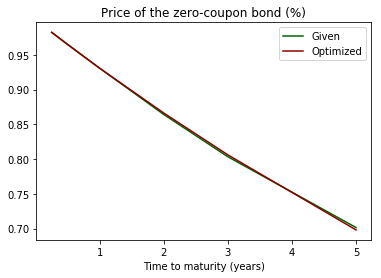

In [20]:

plt.plot(t_actual, pr_p_actual, color = 'darkgreen')
plt.plot(t_actual, pr_my, color = 'darkred')
plt.title('Price of the zero-coupon bond (%)')
plt.xlabel('Time to maturity (years)')
plt.legend(['Given','Optimized']);

In [21]:
print(len(day_discount_rates))
###  Пример использования
print('Ставка на 77 день', day_discount_rates[77])

504
Ставка на 77 день 0.07261188212874636


# IR swap

In [0]:
# Условия
T = 2  # года
tau_fixed = 0.25
tau_float = 0.5
C = 0.074
P = 1000000
M = int(T/tau_fixed)
N = int(T/tau_float) ### количество выплат по плавающей ставке.

Стоимость фиксированной ноги на 1 день:
$$PV_{fixed} = C \cdot \sum_{i=1}^{M} (P \cdot \frac{t_i}{T_i} \cdot df_i )$$
где
$C$ — ставка свопа <br>
$ M $— количество оставшихся периодов фиксированных процентных платежей,  <br>
$ P $— номинальная сумма сделки, <br>
$ t_{i}$— количество дней в процентном периоде $i$ <br>
$ T_{i}$ — финансовая база валюты в соответствии с конвенцией <br>
$ df_{i}$ — фактор дисконтирования.

In [0]:
# Ноги свопа

def PV_float(one_ruon_sim, N, P, tau_float):
    # Все выплаты и их даты
    days_of_float_pays = [int((504-1)*tau_float*(i+1)/T) for i in range(N)]
    ### Датафрэйм выплат,  дисконтированной цены на весь промежуток.
    payments = pd.DataFrame()
    payments['pay'] = np.zeros(504)
    payments['date'] = np.arange(504)
    ### Заполним выплаты
    for d, ors in zip(days_of_float_pays,one_ruon_sim):
        payments['pay'][int(d)]= P*ors/N
    payments['price'] = np.zeros(504)
    ### Найдем цены на каждый день, дисконтируя выплаты.
    for i in range(504):
        for d in days_of_float_pays:
            ### только d>i
            if d > i:
                payments['price'][i] += (payments['pay'][d] / np.power((1+day_discount_rates[d-i]), ((d-i)/252)))
    return payments


def PV_fixed(C, M, P, tau_fixed):
    # Все выплаты и их даты
    one_pay = P*C/M
    days_of_fixed_pays = [int((504-1)*tau_fixed*(i+1)/T) for i in range(M)]
    ######
    payments = pd.DataFrame()
    payments['pay'] = np.zeros(504)
    payments['date'] = np.arange(504)
    for d in days_of_fixed_pays:
           payments['pay'][int(d)]=one_pay
    #one_pay*np.ones(M)
    #payments['date'] = days_of_fixed_pays
    payments['price'] = np.zeros(504)
    for i in range(504):
        for d in days_of_fixed_pays:
            ### только d>i
            if d > i:
                #print('День', d)
                #print('Выплата ', payments['pay'][d])
                #print('Дисконт',1 / np.power((1+day_discount_rates[d-i]), ((d-i)/252)))
                payments['price'][i] += (payments['pay'][d] / np.power((1+day_discount_rates[d-i]), ((d-i)/252)))
                #print('Дисконтированная выплата', (payments['pay'][d] / np.power((1+day_discount_rates[d-i]), ((d-i)/252))))
                #print(payments['price'][i])
    return payments

In [29]:
from tqdm import tqdm_notebook

fixed_payments = PV_fixed(C,M,P,tau_fixed)
ruonia = r_hm_sim
### Симуляции свопа
IR_swap_disc = np.zeros((steps, n_sim))
# необходимые даты
days_of_float_pays = [int((504-1)*tau_float*(i+1)/T) for i in range(N)]
ruonia_necessary = np.asarray([ruonia.T[int(n-1)] for n in days_of_float_pays])
### Доходы - плавающая ставка
for i in tqdm_notebook(range(n_sim)):
  one_ruon_sim = ruonia_necessary.T[i]
  float_payments = PV_float(one_ruon_sim, N, P, tau_float)
  IR_swap_disc.T[i] = float_payments['price'].values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [0]:
## Расходы - фиксированная ставка.
IR_swap_disc = IR_swap_disc - fixed_payments['price'].values.reshape(-1,1)

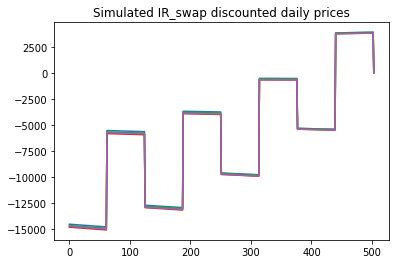

In [38]:
pd.DataFrame(IR_swap_disc[:,:100]).plot(legend=False)
plt.title('Simulated IR_swap discounted daily prices');

# FX forward and FX option

## Evaluation

In [0]:
def gkm_value(S0, rd, rf, T, K=0.014, sigma=0.04, regime='put'):
      """ Valuation of European put/call option in Garman-Kohlhagen model.
      Analytical formula.
      Parameters
      ==========
      S0 : float
      initial stock/index level
      K : float
      strike price
      T : float
      maturity date (in year fractions)
      rd : float
      domestic risk-free short rate
      rf : float
      foreign risk-free short rate
      sigma : float
      volatility factor
      Returns
      =======
      value : float
      present value of the European FX option
      """
    
      d1 = (np.log(S0 / K) + (rd - rf + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
      d2 = d1 - sigma * np.sqrt(T)
      if regime=='put':
        value = (K * np.exp(-rd * T)* stats.norm.cdf(-d2, 0.0, 1.0) - S0 * np.exp(-rf * T) * stats.norm.cdf(-d1, 0.0, 1.0))
        return value
      elif regime=='call':
        value = (S0 * np.exp(-rf * T) * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-rd * T)* stats.norm.cdf(d2, 0.0, 1.0))
        return value
      else:
        return None             


In [0]:
def forward_value(S0, rd, rf, T, K=0.015, N=10**5):
    """ Форвардная цена, умноженная на номинал 
    rf : Безрисковая процентная ставка по иностранной валюте ( LIBOR)
    rd : Безрисковая процентная ставка по домашней валюте ( RUONIA)
    T : Количество лет 
    S0 :  Текущая цена (спот)
    """
    value = N * (S0 * np.exp((rd - rf) * T) - K) 
    
    return value  

In [0]:
def discount(St, r, t):
    """ Дисконтирование стоимости актива
    r : годовая ставка дисконтирования
    t : количество лет
    """
    value = St * np.exp(-r * t)
    
    return value

In [34]:
fx_sim = fx_sim.T
r_hm_sim = r_hm_sim.T
r_fr_sim = r_fr_sim.T
print(fx_sim.shape)
print(r_hm_sim.shape)
print(r_fr_sim.shape)

(504, 5)
(504, 5)
(504, 5)


In [0]:
FX_fwd = np.zeros((steps, n_sim))
FX_opt = np.zeros((steps, n_sim))

FX_fwd_disc = np.zeros((steps, n_sim))
FX_opt_disc = np.zeros((steps, n_sim))

for step in range(steps):
    FX_fwd[step] = forward_value(fx_sim[step], r_hm_sim[step], r_fr_sim[step], 2*(1-step/steps))
    FX_opt[step] = gkm_value(fx_sim[step], r_hm_sim[step], r_fr_sim[step], 2*(1-step/steps))
    
    FX_fwd_disc[step] = discount(FX_fwd[step], day_discount_rates[step], 2*step/steps)
    FX_opt_disc[step] = discount(FX_opt[step], day_discount_rates[step], 2*step/steps)

## Visualization

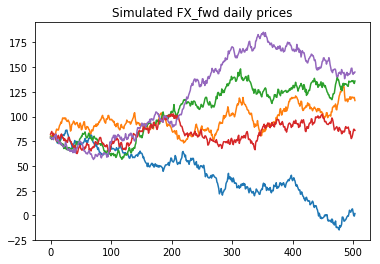

In [36]:
pd.DataFrame(FX_fwd[:,:100]).plot(legend=False)
plt.title('Simulated FX_fwd daily prices');

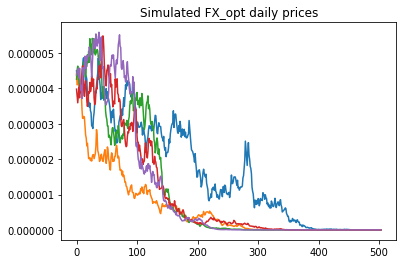

In [37]:
pd.DataFrame(FX_opt[:,:100]).plot(legend=False)
plt.title('Simulated FX_opt daily prices');

# PFE

In [0]:
q = 0.95

IR_swap_PFE = np.quantile(IR_swap_disc, q, axis=1)
FX_fwd_PFE = np.quantile(FX_fwd_disc, q, axis=1)
FX_opt_PFE = np.quantile(FX_opt_disc, q, axis=1)

IR_swap_max_PFE = np.max(IR_swap_PFE)
FX_fwd_max_PFE = np.max(FX_fwd_PFE)
FX_opt_max_PFE = np.max(FX_opt_PFE)

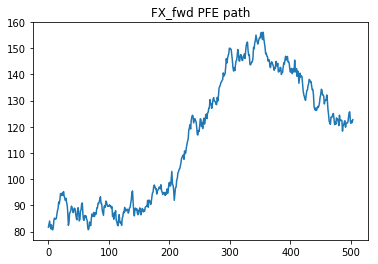

In [49]:
pd.DataFrame(FX_fwd_PFE).plot(legend=False)
plt.title('FX_fwd PFE path');

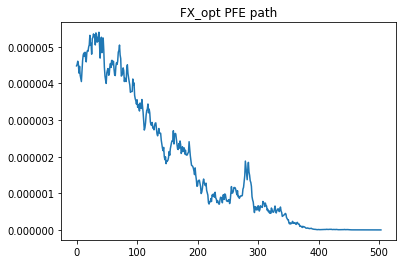

In [50]:
pd.DataFrame(FX_opt_PFE).plot(legend=False)
plt.title('FX_opt PFE path');

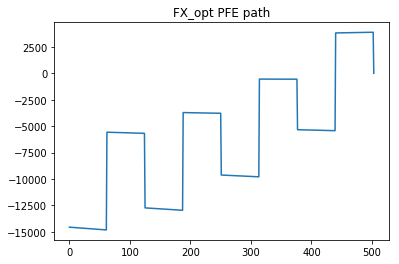

In [51]:
pd.DataFrame(IR_swap_PFE).plot(legend=False)
plt.title('FX_opt PFE path');

In [42]:
print('max PFE для IR_swap_PFE равен {:.7f}'.format(IR_swap_max_PFE))
print('max PFE для FX_fwd_PFE равен {:.7f}'.format(FX_fwd_max_PFE))
print('max PFE для FX_opt_PFE равен {:.7f}'.format(FX_opt_max_PFE))

max PFE для IR_swap_PFE равен 3884.9111247
max PFE для FX_fwd_PFE равен 156.0537533
max PFE для FX_opt_PFE равен 0.0000054
